In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os
import scipy as sp
from scipy.optimize import minimize
from pathlib import Path
from typing import List
from scipy import integrate
import matplotlib.cm as cm
from scipy import signal
from scipy.interpolate import interp1d
from matplotlib.lines import Line2D
import math

In [ ]:
### set plot styles ####
plt.rcParams.update({
    'font.size': 8,
    'text.usetex': True,
    'font.family':'sans-serif',  # Choose appropriate font family
})

!sudo apt install cm-super dvipng texlive-latex-extra texlive-latex-recommended

# Rubber bands

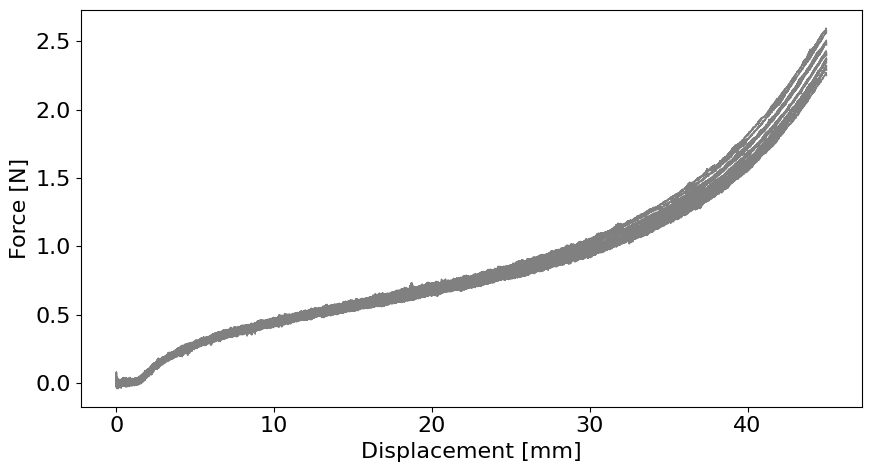

In [ ]:
data_files = sorted(
    list(Path('./Rubber_bands').glob("*.txt"))
)

data_1 = data_files[5:10]
data_2 = data_files[15:20]
data_3 = data_files[25:30]
data_4 = data_1 + data_2 + data_3

def get_extension_data(paths: List[str]):
    return

def read_instron_data(path: str):
    time, displacement, force = np.loadtxt(path, skiprows=3, delimiter=" ", unpack=True)
    return time, displacement, force


def plot_raw_force_displacement_curves(paths: List[str], **plot_kwargs):
    fig, axes = plt.subplots(figsize=(9, 5))

    for file in paths:
        _, u, f = read_instron_data(file)
        axes.plot(u[:len(u)//2], f[:len(u)//2], **plot_kwargs)
        #print(len(u))

    axes.set(xlabel="Displacement [mm]", ylabel="Force [N]")
    fig.tight_layout()

    return fig, axes
fig, axes = plot_raw_force_displacement_curves(data_4, lw=1, color="gray", label="Experiment")

0.028548624974426895


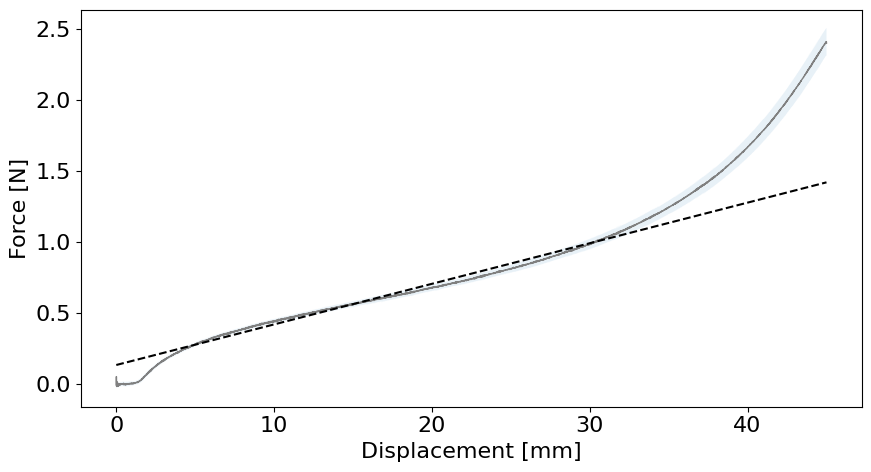

In [ ]:
def plot_average_force_displacement_curve(paths: List[str], **plot_kwargs):
    fig, axes = plt.subplots(figsize=(9, 5))
    F = []
    U = []
    for file in paths:
        _, u, f = read_instron_data(file)
        U.append(u[:len(u)//2])
        F.append(f[:len(u)//2])
        #print(len(u))
    mean_u = np.mean(U, axis=0)
    mean_f = np.mean(F, axis=0)
    std_f = np.std(F, axis=0)
    coef = np.polyfit(mean_u[(mean_u>5)&(mean_u<35)],mean_f[(mean_u>5)&(mean_u<35)],1)
    polyfit_fn = np.poly1d(coef)
    axes.plot(mean_u, mean_f, **plot_kwargs)
    axes.plot(mean_u, polyfit_fn(mean_u),'--k')
    axes.fill_between(mean_u, mean_f-std_f, mean_f+std_f, alpha=0.1)
    axes.set(xlabel="Displacement [mm]", ylabel="Force [N]")
    fig.tight_layout()
    print(coef[0])
    return fig, axes, coef[0]

fig, axes, k_rubber = plot_average_force_displacement_curve(data_4, lw=1, color="gray", label="Experiment")

# Analytical

In [ ]:
l0_rubber = 10
r = 10*np.sqrt(2)
rotation = (np.linspace(-45,45,10))/180*np.pi
rot1,rot2 = np.meshgrid(rotation,rotation)

### converts the instron displacement to angles
def find_angle(r,l,dx):
    x = dx+l-r*np.sqrt(2)/2
    h = r*np.sqrt(2)/2
    angle = -np.arccos((1/(2*r**2*(h**2+x**2)))*(-l**2*r*x+h**2*r*x + r**3*x + r*x**3 - np.sqrt(-h**2*r**2*(l**4 + (h**2 - r**2 + x**2)**2 - 2*l**2*(h**2 + r**2 + x**2)))))
    return angle+np.pi/2

def position_bar(l_bar, r, theta):
    dx = r*np.cos(theta)-r*np.cos(theta[0])
    dy = np.sqrt(l_bar**2-dx**2)
    return dx,dy

def calc_force(p0,p1,p2,p3,l_bar, r,k_rubber,theta1,theta2):
    #Calc positions of rubber band
    x0, y0 = p0
    x1, y1 = p1
    x2, y2 = p2
    x3, y3 = p3
    dx1 = -x0 + r*np.cos(theta1) + x1
    dy1 = -y0 + r*np.sin(theta1) + y1
    dx2 = -x2 + r*np.cos(theta2) + x3
    dy2 = -y2 + r*np.sin(theta2) + y3

    #Calc Forces rubber band
    extension1 = np.sqrt(dx1**2+dy1**2)-l0_rubber
    F_spring1 = -k_rubber*extension1
    Fspring_x1 = F_spring1*dx1/np.sqrt(dx1**2+dy1**2)
    Fspring_y1= F_spring1*dy1/np.sqrt(dx1**2+dy1**2)

    extension2 = np.sqrt(dx2**2+dy2**2)-l0_rubber
    F_spring2 = -k_rubber*extension2
    Fspring_x2 = F_spring2*dx2/np.sqrt(dx2**2+dy2**2)
    Fspring_y2= F_spring2*dy2/np.sqrt(dx2**2+dy2**2)

    # Calc direction hinges and bar
    dx1_hinge, dy1_hinge = r*(np.cos(theta1)),r*(np.sin(theta1))
    hinge_ratio1 = dy1_hinge/dx1_hinge
    dx1_bar, dy1_bar = position_bar(l_bar,r,[theta1])
    bar_ratio1 = dx1_bar/dy1_bar

    dx2_hinge, dy2_hinge = r*(np.cos(theta2)),r*(np.sin(theta2))
    hinge_ratio2 = dy2_hinge/dx2_hinge
    dx2_bar, dy2_bar = position_bar(l_bar,r,[theta2])
    bar_ratio2 = dx2_bar/dy2_bar

    #calc instron force
    Finstron_y1 = (hinge_ratio1*Fspring_x1-Fspring_y1)/(1-bar_ratio1*hinge_ratio1)
    Finstron_y2 = (hinge_ratio2*Fspring_x2-Fspring_y2)/(1-bar_ratio2*hinge_ratio2)

    #print(F_y[0])
    E = k_rubber/2*(extension1**2+extension2**2)
    return E,Finstron_y1,Finstron_y2

(50, 50)


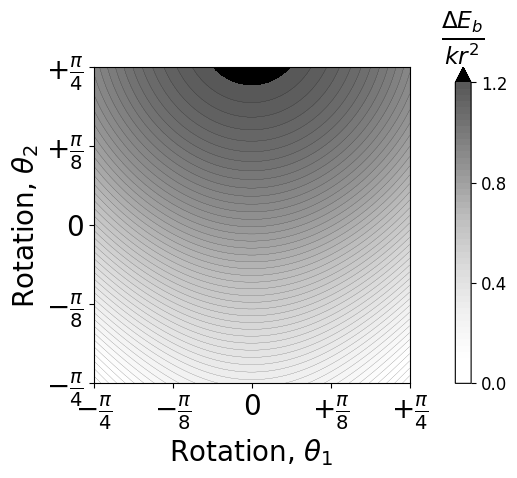

1


In [ ]:
### print 2D energy landscape ###

# unit1_id1 = ['MM','MB','MLB','MRB','ML','MR','MT','MLT','MRT']
# id_p2 =[[10,0],[0,0],[0,15],[0,-15],[10,15],[10,-15],[20,0],[20,15],[20,-15]]
unit1_id1 = ['MLB']
id_p2 =[[0,15]]
id_p1 = [[10,0]]
#id_p1 =[[10,0]]
p0_1 = [-10,0]
l_bar = 70
count = 0
rotation = (np.linspace(-45,45,50))/180*np.pi
rot1,rot2 = np.meshgrid(rotation,rotation)


for i in range(len(id_p1)):
    for ii in range(len(id_p2)):
        E, F1,F2 = calc_force(p0_1,id_p1[i],p0_1,id_p2[ii],l_bar, r,k_rubber,rot1,rot2)
        # plots contour lines
        fig, ax = plt.subplots(figsize=(6, 5))
        font = {'size': 20}
        plt.rc('font', **font)
        ## set ticks to pi
        unit   = 0.125
        x_tick = np.arange(-0.25, 0.25+unit, unit)
        x_label = [r"$-\frac{\pi}{4}$", r"$-\frac{\pi}{8}$", r"$0$", r"$+\frac{\pi}{8}$",   r"$+\frac{\pi}{4}$"]
        ax.set_xticks(x_tick*np.pi)
        ax.set_aspect('equal', 'box')
        ax.set_xticklabels(x_label, fontsize=20)
        y_tick = np.arange(-0.25, 0.25+unit, unit)
        y_label = [r"$-\frac{\pi}{4}$", r"$-\frac{\pi}{8}$", r"$0$", r"$+\frac{\pi}{8}$",   r"$+\frac{\pi}{4}$"]
        ax.set_yticks(y_tick*np.pi)
        ax.set_yticklabels(y_label, fontsize=20)

        myvals = (E-E[0,0])/(k_rubber*r**2)
        mymin = np.min(myvals)
        mymax = np.max(myvals)
        myroundmin = np.floor(mymin//0.2)*0.2
        myroundmax =np.ceil(mymax//0.2)*0.2
        myticks = np.arange(mymin, mymax,0.2)

        # cp = plt.contourf(rot1, rot2, (E-E[0,0])/(k_rubber*r**2),50,cmap = 'coolwarm')
        cp = plt.contourf(rot1, rot2, (E-E[0,0])/(k_rubber*r**2),50,cmap = 'Greys',vmin = 0.1, vmax = 1.6,extend = 'max')
        cp2 = plt.contour(rot1, rot2, (E-E[0,0])/(k_rubber*r**2),50,colors = 'k',linewidths = 0.1,vmin=-1,vmax = 0.25)
        clb = plt.colorbar(cp, pad= 0.1, extend='max')
        clb.ax.tick_params(labelsize=12)
        clb.ax.set_title(r"$\frac{\Delta E_b}{k r^2}$")
        clb.ax.tick_params(labelsize=12)
        clb.set_ticks([0.0,0.4,0.8,1.2])
        #clb.ax.set_yticks(myticks)
        #ax.set_title('Contour Plot')
        ax.set_xlabel('Rotation, '+r'$\theta_1$', fontsize = 20)
        ax.set_ylabel('Rotation, '+r'$\theta_2$', fontsize = 20)
        count += 1

        idx1 = 0
        idx2 = 0
        t1_forward = [rotation[0]]
        t2_forward = [rotation[0]]
        n = len(rotation)
        print(E.shape)
      
        plt.tight_layout()
        fig.savefig(r'./2unit_EnergyLandscap_MMBL_grey.pdf', dpi=600)

        plt.show()

print(count)


## Nelder Mead 

In [ ]:
id_p2 =[20,15]
id_p1 = [10,0]
p0_1 = [-10,0]
l0_rubber = 10
l_bar = 70
r = 10*np.sqrt(2)
u = np.linspace(-20,20,50)
rot1 = (np.linspace(-45,45,200))/180*np.pi
rot1_opt = np.zeros(len(u))

def calc_E(theta1,u,p0,p1,p2,p3,l_bar, r,k_rubber):
    #Calc positions of rubber band
    #print(p0,p1,p2,p3)
    x0, y0 = p0
    x1, y1 = p1
    x2, y2 = p2
    x3, y3 = p3
    #theta2 = theta1[::-1]
    theta2 = get_R2(u,theta1)
    dx1 = -x0 + r*np.cos(theta1) + x1
    dy1 = -y0 + r*np.sin(theta1) + y1
    dx2 = -x2 + r*np.cos(theta2) + x3
    dy2 = -y2 + r*np.sin(theta2) + y3

    #Calc Forces rubber band
    extension1 = np.sqrt(dx1**2+dy1**2)-l0_rubber
    F_spring1 = -k_rubber*extension1
    Fspring_x1 = F_spring1*dx1/np.sqrt(dx1**2+dy1**2)
    Fspring_y1= F_spring1*dy1/np.sqrt(dx1**2+dy1**2)

    extension2 = np.sqrt(dx2**2+dy2**2)-l0_rubber
    F_spring2 = -k_rubber*extension2
    Fspring_x2 = F_spring2*dx2/np.sqrt(dx2**2+dy2**2)
    Fspring_y2= F_spring2*dy2/np.sqrt(dx2**2+dy2**2)
    E = k_rubber/2*(extension1**2+extension2**2)
    return E

def get_R2(u,rot1):
    return np.arcsin(u/r-np.sin(rot1))

def get_E(rot1,u,p0_1,id_p1,id_p2,k_rubber):
    E = np.zeros(len(rot1))
    rot2 = get_R2(u,rot1)
    for i in range(len(rot1)):
        if rot2[i] > rot1[0] and rot2[i] < rot1[-1]:
            E[i] = calc_E(rot1[i],u,p0_1,id_p1,p0_1,id_p2,l_bar, r,k_rubber)/(k_rubber*r**2)
        else: E[i] = np.nan
    return E

def min_E_path(p0_1,id_p1,id_p2,k_rubber):

    if calc_force(p0_1,id_p1,p0_1,id_p2,l_bar, r,k_rubber,rot1[0]+0.0001,rot1[0])[0]< calc_force(p0_1,id_p1,p0_1,id_p2,l_bar, r,k_rubber,rot1[0],rot1[0]+0.0001)[0]:
        idx = int(-1)
    else: idx = int(0)

    mymap =plt.get_cmap('magma')
    colors = mymap(np.linspace(0.2,0.8, len(u)+1))
    F_min = np.zeros(len(u))
    E_min = np.zeros(len(u))
    rot1_min = np.zeros(len(u))
    rot2_min = np.zeros(len(u))

    for i in range(len(u)):
        E = get_E(rot1,u[i],p0_1,id_p1,id_p2,k_rubber)
        rot1_1 = rot1[~np.isnan(E)]
        bnds = sp.optimize.Bounds(rot1_1[0],rot1_1[-1])
        #print(bnds)
        min = minimize(calc_E, rot1_1[idx],args=(u[i],p0_1,id_p1,p0_1,id_p2,l_bar, r,k_rubber),bounds=bnds)
        #print(min)
        #print(min.x)
        rot2_minimum = get_R2(u[i],min.x)
        E_minimum,F1_min,F2_min = calc_force(p0_1,id_p1,p0_1,id_p2,l_bar, r,k_rubber,min.x,rot2_minimum)
        #print(min.x)
        if rot1[0]< min.x < rot1[-1]:
            F_min[i] = F1_min
        else: F_min[i] = F2_min
        E_min[i] = E_minimum
        rot2_min[i] = rot2_minimum
        rot1_min[i] = min.x
        #print(E_min)
        #print(min.fun/(k_rubber*r**2))

        ##### Make plot ####
        # plt.plot(rot1,E,c=colors[i])
        # plt.scatter(min.x,E_min,c=np.atleast_2d(colors[i]))
        # plt.ylabel('Energy')
        # plt.xlabel('rotation 1')

    return idx,rot1_min, rot2_min, E_min, F_min

start_block,rot1_min,rot2_min, E_min, F_min = min_E_path(p0_1,id_p1,id_p2,k_rubber)


<ipython-input-15-1a576f3ddf63>:39: RuntimeWarning: invalid value encountered in arcsin
  return np.arcsin(u/r-np.sin(rot1))


-0.7853981633974483 -20.0
-0.7143571234921515 -19.183673469387756
-0.6354226347084884 -18.367346938775512
-0.5643815948031914 -17.551020408163264
-0.5012340037762609 -16.73469387755102
-0.4380864127493304 -15.918367346938776
-0.3749388217223999 -15.10204081632653
-0.31179123069546943 -14.285714285714285
-0.2486436396685389 -13.46938775510204
-0.19338949751997467 -12.653061224489797
-0.13813535537141047 -11.83673469387755
-0.07498776434447996 -11.020408163265305
-0.019733622195915745 -10.204081632653061
0.03552051995264847 -9.387755102040817
0.09866811097957896 -8.571428571428571
0.1539222531281432 -7.755102040816325
0.21706984415507372 -6.938775510204081
0.2723239863036379 -6.122448979591837
0.33547157733056826 -5.3061224489795915
0.39861916835749894 -4.489795918367346
0.4617667593844293 -3.6734693877551017
0.5249143504113599 -2.8571428571428577
0.5959553903166569 -2.04081632653061
0.6669964302219535 -1.224489795918366
0.7380374701272504 -0.408163265306122
0.7853981633974483 0.40816326

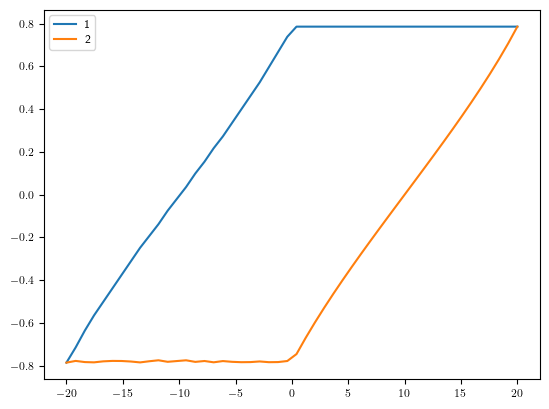

In [ ]:

#plt.plot(u,F_min/(k_rubber*r))
plt.plot(u,rot1_min,label = '1')
plt.plot(u,rot2_min, label = '2')
plt.legend()
for i in range(len(rot2_min)):
    print(rot1_min[i],u[i])
print(np.diff(rot1_min))

<ipython-input-68-dd71fce85476>:39: RuntimeWarning: invalid value encountered in arcsin
  return np.arcsin(u/r-np.sin(rot1))


Streaming output truncated to the last 5000 lines.
25.0
37501
25.0
37502
25.0
37503
25.0
37504
25.0
37505
25.0
37506
25.0
37507
25.0
37508
25.0
37509
25.0
37510
25.0
37511
25.0
37512
25.0
37513
25.0
37514
25.0
37515
25.0
37516
25.0
37517
25.0
37518
25.0
37519
25.0
37520
25.0
37521
25.0
37522
25.0
37523
25.0
37524
25.0
37525
25.0
37526
25.0
37527
25.0
37528
25.0
37529
25.0
37530
25.0
37531
25.0
37532
25.0
37533
25.0
37534
25.0
37535
25.0
37536
25.0
37537
25.0
37538
25.0
37539
25.0
37540
25.0
37541
25.0
37542
25.0
37543
25.0
37544
25.0
37545
25.0
37546
25.0
37547
25.0
37548
25.0
37549
25.0
37550
25.0
37551
25.0
37552
25.0
37553
25.0
37554
25.0
37555
25.0
37556
25.0
37557
25.0
37558
25.0
37559
25.0
37560
25.0
37561
25.0
37562
25.0
37563
25.0
37564
25.0
37565
25.0
37566
25.0
37567
25.0
37568
25.0
37569
25.0
37570
25.0
37571
25.0
37572
25.0
37573
25.0
37574
25.0
37575
25.0
37576
25.0
37577
25.0
37578
25.0
37579
25.0
37580
25.0
37581
25.0
37582
25.0
37583
25.0
37584
25.0
37585
25.0
37586
25.

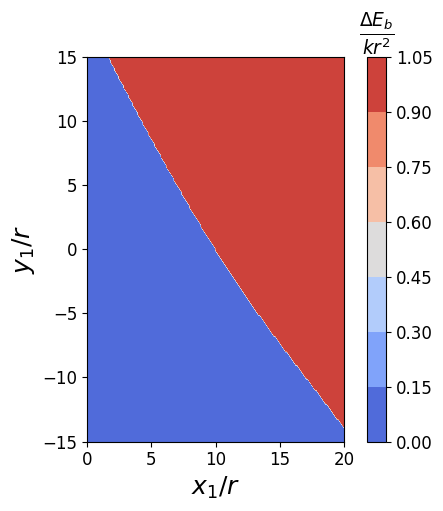

In [ ]:
from numpy.core.function_base import linspace
N = 200
X = np.linspace(0,20,N)
Y = np.linspace(-15,15,N)
x,y = np.meshgrid(X,Y)
idx_seq = np.zeros((N,N))
rot1 = (np.linspace(-45,45,100))/180*np.pi
count = 0

for i in range(N):
    for j in range(N):
        p2 = [x[i,j],y[i,j]]
        start_block,rot1_min,rot2_min, E_min, F_min = min_E_path(p0_1,id_p1,p2,k_rubber)
        # fig, ax = plt.subplots(figsize=(6, 5))
        # plt.plot(u,rot1_min)
        # plt.plot(u,rot2_min)
        # plt.show
        # print(rot1[len(rot1_min)//2])
        print(len(rot1_min)/2)
        if rot1_min[25] > 0.75:
            idx_seq[i,j] = 1
        count += 1
        print(count)
# rot1 = (np.linspace(45,-45,200))/180*np.pi
# for i in range(N):
#     for j in range(N):
#         start_block,rot1_min,rot2_min, E_min, F_min = min_E_path(p0_1,id_p1,p2,k_rubber)
#         if idx_seq[i,j] == 0:
#             if rot1[len(rot1)//2] > 0.75:
#                 idx_seq[i,j] = 2
#         if idx_seq[i,j] == 0:
#             if rot1[len(rot1)//2] > 0.75:
#                 idx_seq[i,j] = 3
#         count += 1
#         print(count)

fig, ax = plt.subplots(figsize=(6, 5))
ax.set_aspect('equal', 'box')
cp = plt.contourf(x, y, idx_seq,cmap = 'coolwarm')
clb = plt.colorbar(cp)
clb.ax.set_title(r"$\frac{\Delta E_b}{k r^2}$")
clb.ax.tick_params(labelsize=12)
plt.xlabel(r"$x_1/r$", fontsize=18)
plt.ylabel(r"$y_1/r$", fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=12)
#ax.set(xlabel= r"$x_1/r$",ylabel= r"$y_1/r$")



plt.show()


In [ ]:
#### find snapping points ####

from numpy.core.function_base import linspace
N = 160
X = np.linspace(0,20,N)
Y = np.linspace(-15,15,N)
x,y = np.meshgrid(X,Y)
snap = np.zeros((N,N))
u = np.linspace(-20,20,100)
rot1 = (np.linspace(-45,45,100))/180*np.pi
count = 0

for i in range(N):
    for j in range(N):
            p2 = [x[i,j],y[i,j]]
            start_block,rot1_min,rot2_min, E_min, F_min = min_E_path(p0_1,id_p1,p2,k_rubber)
            rot1_dif = np.abs(np.diff(rot1_min))
            snappoint = np.argmax(rot1_dif)
            print(p2)
            #print(rot1_dif)
            print(rot1_dif[snappoint])
            if rot1_dif[snappoint] > 0.05:
                snap[i,j] = ((u[snappoint]+20)/80)
                #print(u[snappoint])
            else: snap[i,j] = 0.5
            #print(snap[i,j])
            count += 1
            print(count)
print(snap)
np.savetxt(r'./snap_half.txt',snap,delimiter=',')
snap += snap[::-1,:]
print(snap)
np.savetxt(r'./snap_full.txt',snap,delimiter=',')

fig, ax = plt.subplots(figsize=(6, 5))
ax.set_aspect('equal', 'box')
cp = plt.contourf(x, y, snap,cmap = 'coolwarm')
clb = plt.colorbar(cp)
clb.ax.set_title(r"$\frac{\Delta E_b}{k r^2}$")
clb.ax.tick_params(labelsize=12)
plt.xlabel(r"$x_1/r$", fontsize=18)
plt.ylabel(r"$y_1/r$", fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=12)
#ax.set(xlabel= r"$x_1/r$",ylabel= r"$y_1/r$")

plt.show()

<ipython-input-18-dd71fce85476>:39: RuntimeWarning: invalid value encountered in arcsin
  return np.arcsin(u/r-np.sin(rot1))


Streaming output truncated to the last 5000 lines.
0.11106640694509362
12547
[8.427672955974844, -0.28301886792452713]
0.06346651825433935
12548
[8.553459119496855, -0.28301886792452713]
0.06346651825433935
12549
[8.679245283018869, -0.28301886792452713]
0.06346651825433935
12550
[8.80503144654088, -0.28301886792452713]
0.06346651825433935
12551
[8.930817610062894, -0.28301886792452713]
0.06346651825433935
12552
[9.056603773584905, -0.28301886792452713]
0.06346651825433935
12553
[9.182389937106919, -0.28301886792452713]
0.04759988869075443
12554
[9.30817610062893, -0.28301886792452713]
0.04759988869075443
12555
[9.433962264150944, -0.28301886792452713]
0.04759988869075443
12556
[9.559748427672956, -0.28301886792452713]
0.04759988869075443
12557
[9.685534591194969, -0.28301886792452713]
0.04759988869075443
12558
[9.81132075471698, -0.28301886792452713]
0.04759988869075443
12559
[9.937106918238994, -0.28301886792452713]
0.04759988869075443
12560
[10.062893081761006, -0.28301886792452713]

[[0.57653061 1.         1.         1.         1.         1.
  1.         1.        ]
 [0.33673469 0.62755102 1.         1.         1.         1.
  1.         0.65816327]
 [0.35714286 0.39795918 0.68877551 1.         1.         1.
  0.68877551 0.67857143]
 [0.35714286 0.40816327 0.44897959 1.         1.         0.71938776
  0.70918367 0.41836735]
 [0.35714286 0.40816327 0.44897959 1.         1.         0.71938776
  0.70918367 0.41836735]
 [0.35714286 0.39795918 0.68877551 1.         1.         1.
  0.68877551 0.67857143]
 [0.33673469 0.62755102 1.         1.         1.         1.
  1.         0.65816327]
 [0.57653061 1.         1.         1.         1.         1.
  1.         1.        ]]


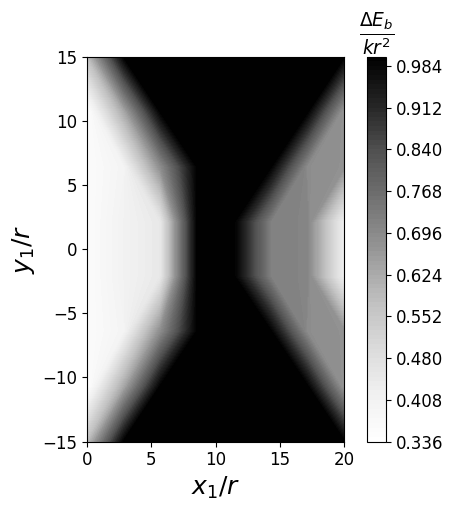

In [ ]:
### plot snapping points ###

fig, ax = plt.subplots(figsize=(6, 5))
ax.set_aspect('equal', 'box')
cp = plt.contourf(x, y, snap,100,cmap = 'Greys')
clb = plt.colorbar(cp)
clb.ax.set_title(r"$\frac{\Delta E_b}{k r^2}$")
clb.ax.tick_params(labelsize=12)
plt.xlabel(r"$x_1/r$", fontsize=18)
plt.ylabel(r"$y_1/r$", fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=12)
#ax.set(xlabel= r"$x_1/r$",ylabel= r"$y_1/r$")

print(snap)

# Experiments

## 2 unit (00) -> (11)  

### Internal systematic error

(3004,)
(3004,)
(3004,)
(3004,)
(3004,)


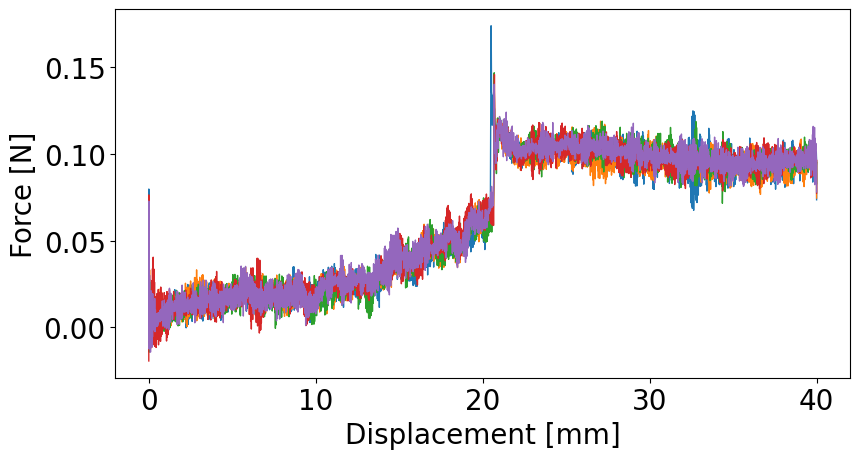

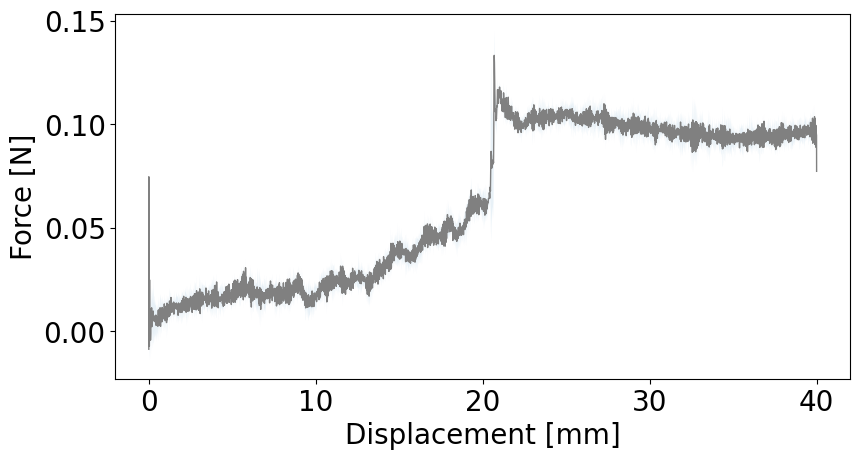

In [ ]:
friction_2Unit = sorted(
    list(Path('./2unit_00_11/2unit_friction_good.is_tcyclic_Exports').glob("*.txt"))
)
def read_instron_data(path: str):
    time, displacement, force = np.loadtxt(path, skiprows=3, delimiter=" ", unpack=True)
    return time, displacement, force


def plot_raw_force_displacement_curves(paths: List[str], **plot_kwargs):
    fig, axes = plt.subplots(figsize=(9, 5))

    for file in paths:
        _, u, f = read_instron_data(file)
        print(u.shape)
        #axes.plot(u[:len(u)//2], f[:len(u)//2], **plot_kwargs)
        axes.plot(u[:len(u)], f[:len(u)], **plot_kwargs)
        #print(len(u))

    axes.set(xlabel="Displacement [mm]", ylabel="Force [N]")
    fig.tight_layout()

    return fig, axes
fig, axes = plot_raw_force_displacement_curves(friction_2Unit, lw=1, label="Experiment")

def tolerant_mean(arrs):
    lens = [len(i) for i in arrs]
    arr = np.ma.empty((np.max(lens),len(arrs)))
    arr.mask = True
    for idx, l in enumerate(arrs):
        arr[:len(l),idx] = l
    return arr.mean(axis = -1), arr.std(axis=-1)


def plot_average_curve(paths: List[str], **plot_kwargs):
    fig, axes = plt.subplots(figsize=(9, 5))
    F = []
    U = []
    for file in paths:
        _, u, f = read_instron_data(file)
        U.append(u[:len(u)])
        F.append(f[:len(u)])
        #print(len(u))
    mean_u, std_u = tolerant_mean(U)
    mean_f, std_f = tolerant_mean(F)
    axes.plot(mean_u, mean_f, **plot_kwargs)
    axes.fill_between(mean_u, mean_f-std_f, mean_f+std_f, alpha=0.1)
    axes.set(xlabel="Displacement [mm]", ylabel="Force [N]")
    fig.tight_layout()
    return fig, axes, mean_f

fig, axes, unit2_friction = plot_average_curve(friction_2Unit, lw=1, color="gray", label="Experiment")



### plot curves

MMM


<ipython-input-15-1a576f3ddf63>:39: RuntimeWarning: invalid value encountered in arcsin
  return np.arcsin(u/r-np.sin(rot1))


MMB
6004
MML
MMR
MMT


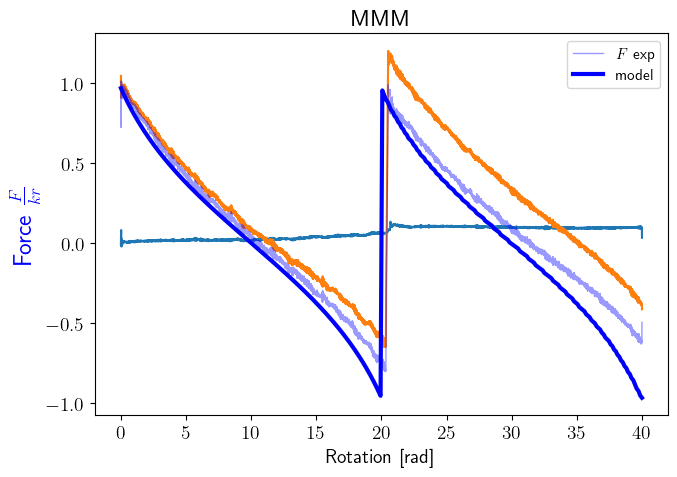

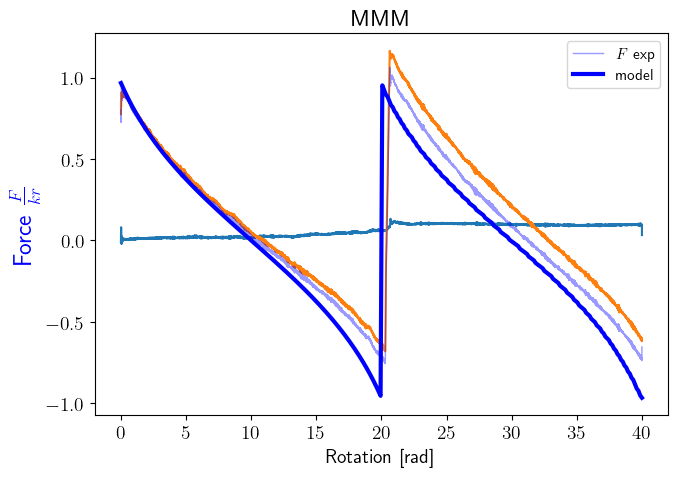

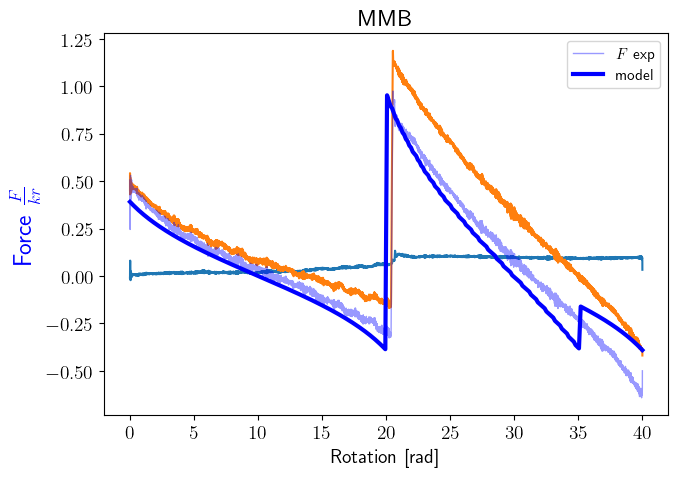

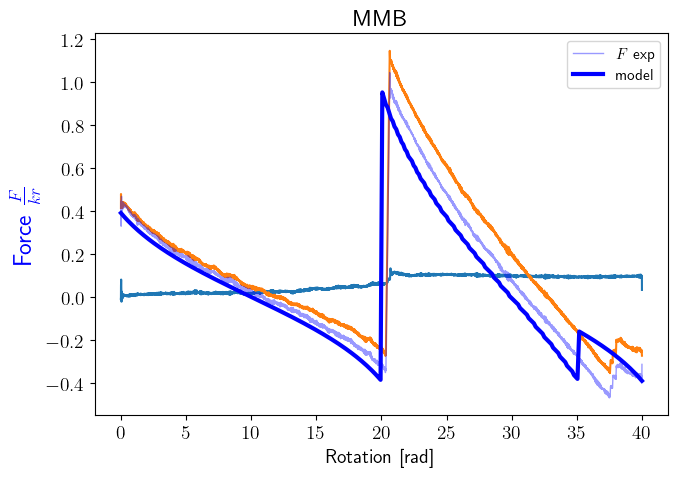

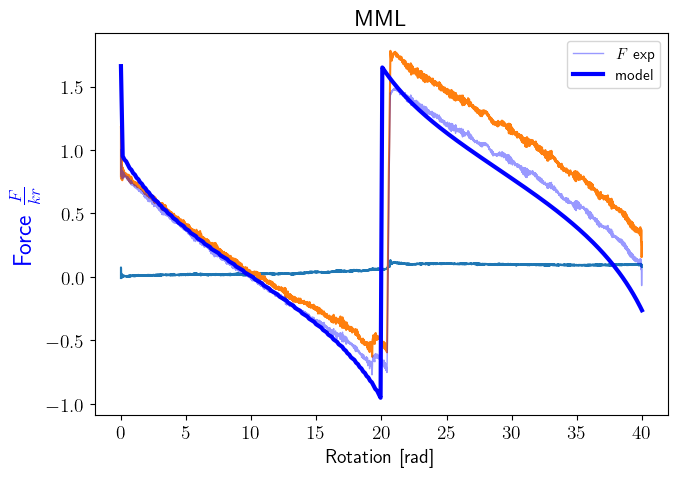

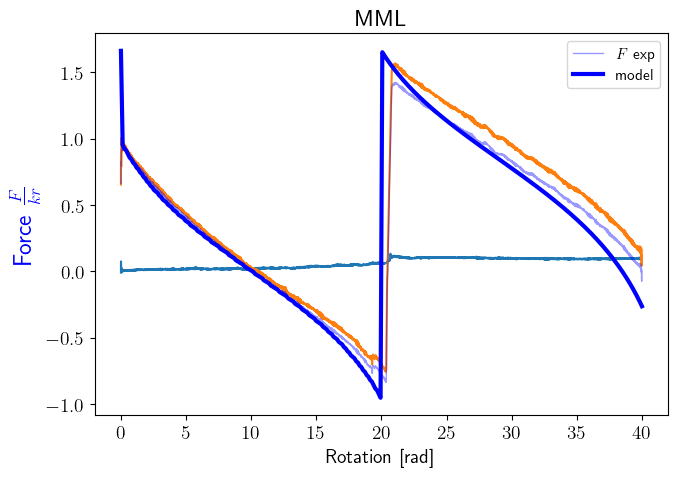

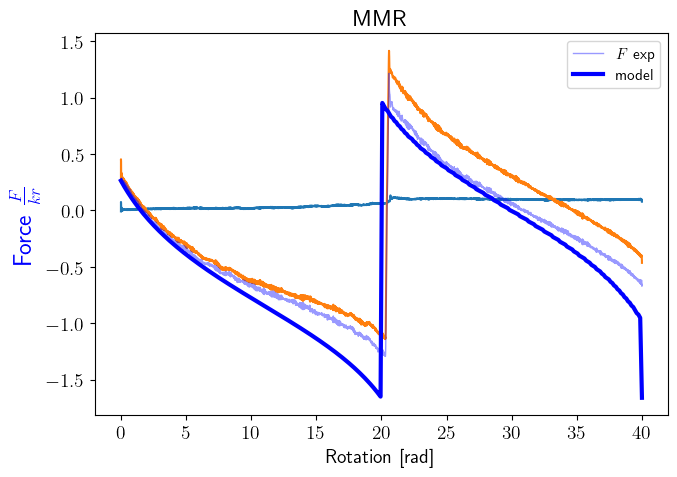

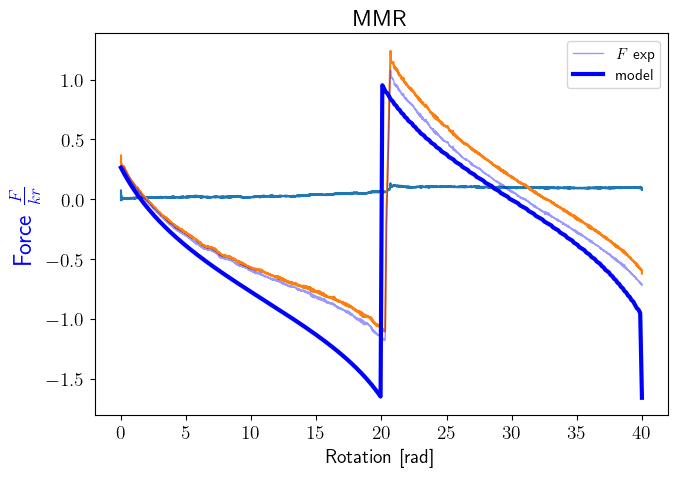

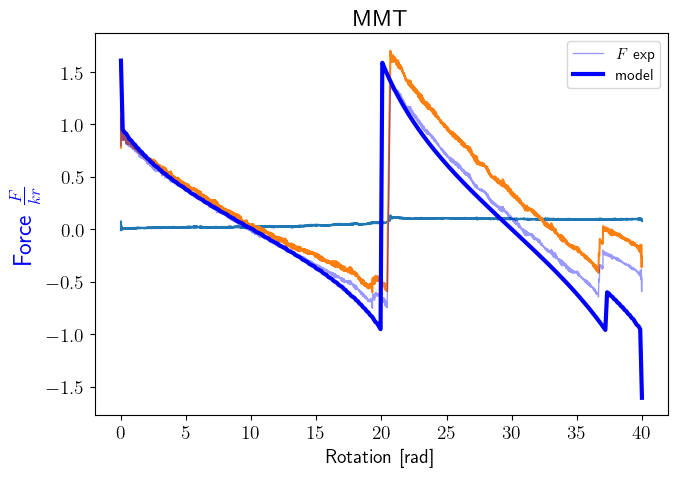

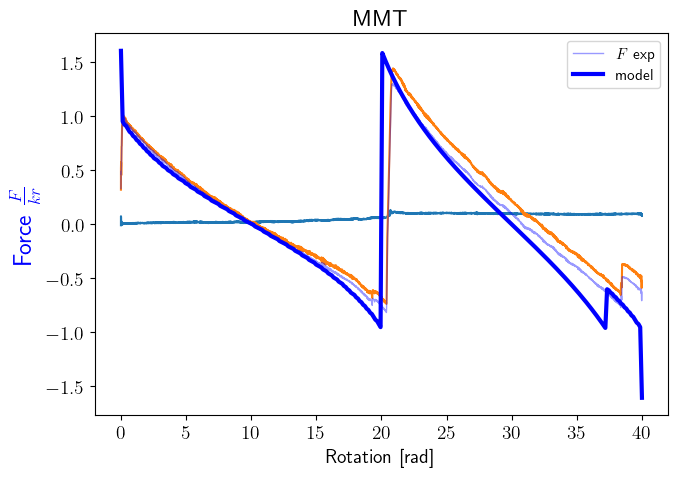

In [ ]:
units = ['1unit','1unit_','2unit','2unit_2']
unit2_id1 = ['MMM','MMB','MML','MMR','MMT']
id_p2 =[[10,0],[0,0],[10,15],[10,-15],[20,0]]
id_p1 = [10,0]
p0_1 = [-10,0]
l_bar = 70
r = 10*np.sqrt(2)
u = np.linspace(-20,20,300)
rot1 = (np.linspace(-45,45,200))/180*np.pi

def plot_energy_curves(paths: List[str], syst_error,k,r,l,id,id_p, **plot_kwargs):
    fig, axes = plt.subplots(figsize=(7, 5))
    font = {'size': 14}
    plt.rc('font', **font)


    #### analytical minimum path ####
    start_block, rot1_min, rot2_min, E_min, F_min = min_E_path(p0_1,id_p1,id_p2[id_p],k)

    #### Experimental data ####
    F = []
    Theta = []
    U = []
    for file in paths:
        _, u_exp, f_exp = read_instron_data(file)
        U.append(u_exp)
        F.append(f_exp)
    for i in range(len(U)):
        if len(U[i]) != len(U[0]):
            U_interp = interp1d(U[i], U[i], 'linear')
            F_interp = interp1d(U[i], F[i], 'linear')
            U[i],F[i] = U_interp(U[0]),F_interp(U[0])
            # U[i] = signal.resample(U[i],len(U[0]))
            # F[i] = signal.resample(F[i],len(U[0]))
            print(len(U[i]))
    mean_u, std_u = tolerant_mean(U)
    mean_f, std_f = tolerant_mean(F)
    err = signal.resample(unit2_friction,len(mean_f))
    if start_block == 0:
        mean_f -= err
    else:
        mean_f -= err[::-1]
    E_exp = integrate.cumtrapz(mean_f, mean_u, initial=0)

    #### Make plots ####


    axes.plot(mean_u,err)
    axes.plot(mean_u,(mean_f+err)/(k*r))
    lns1 = axes.plot(mean_u, mean_f/(k*r),color='blue',alpha = 0.4,lw=1, **plot_kwargs,label = r'$F$   exp')
    lns2 = axes.plot(u+20,F_min/(k*r),color='blue',lw =3,label = '     model')

    #axes.fill_between(mean_theta, mean_f-std_f, mean_f+std_f, alpha=0.1)
    axes.set(xlabel="Rotation [rad]", ylabel="Force [N]",title=id)
    axes.set_ylabel("Force   "+ r'$\frac{F}{kr}$', color = 'blue', fontsize=18)
    #axes.legend()
    #axes2=axes.twinx()
    #lns3 = axes2.plot(mean_u, E_exp/(k*r**2),color='red',alpha = 0.4,lw =3,**plot_kwargs, label = r'$E$   exp')
    #lns4 = axes2.plot(u+20,(E_min-E_min[0])/(k*r**2),color = 'red',lw=3,label = '    model')
    #axes2.legend()
   # axes.fill_between(mean_theta, mean_f-std_f, mean_f+std_f, alpha=0.1)
    #axes2.set(xlabel="Rotation [rad]", ylabel="Energy",title=id)
    #axes2.set_ylabel("Energy   " +r'$\frac{dE}{kr^2}$',color = 'red', fontsize=18)
    fig.tight_layout()

    lns = lns1+lns2
    #lns = lns1+lns2+lns3+lns4
    labs = [l.get_label() for l in lns]
    axes.legend(lns, labs, loc=0, fontsize = 11)

    # fig, axes = plt.subplots(figsize=(9, 5))
    # axes.plot(mean_theta,np.gradient(E_exp,mean_u),color='blue',label = 'experiment')
    if id_p == 0:
        fig.savefig(r'./internal_friction_2.pdf', dpi=600)
    return F_min,mean_f,E_min,E_exp #,fig, axes

All_F = []
All_F_exp = []
All_E = []
All_E_exp = []
All_mean_theta = []
for idx, elem in enumerate(unit2_id1):
    unit1_data = sorted(list(Path(f'./2unit_00_11/2unit_{elem}.is_tcyclic_Exports').glob("*.txt")))
    unit2_1 = unit1_data[:3] #1 rubber band
    unit2_2 = unit1_data[3:6] #2 rubber bands
    print(elem)
    F_min,F_exp,E_min,E_exp = plot_energy_curves(unit2_1,unit2_friction,k_rubber,r,l_bar,elem,idx)
    All_F.append(F_min)
    All_F_exp.append(F_exp)
    All_E.append(E_min)
    All_E_exp.append(E_exp)
    F_min,F_exp,E_min,E_exp = plot_energy_curves(unit2_2,unit2_friction,2*k_rubber, r,l_bar,elem,idx)
    All_F.append(F_min)
    All_F_exp.append(F_exp)
    All_E.append(E_min)
    All_E_exp.append(E_exp)

## backward path (11) -> (00)

### k_rubber backward experiments

0.03030007107200356


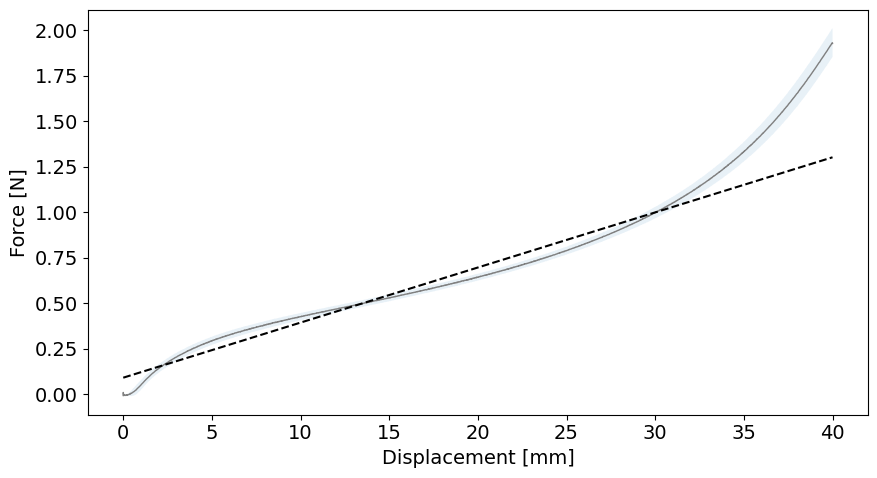

In [ ]:
data_rubber_back = sorted(
    list(Path('./15Aug_Tests/2unit/2unit_Rubber.is_tcyclic_Exports').glob("*.txt"))
)
fig, axes, k_rubber_back = plot_average_force_displacement_curve(data_rubber_back, lw=1, color="gray", label="Experiment")

### internal systematic error

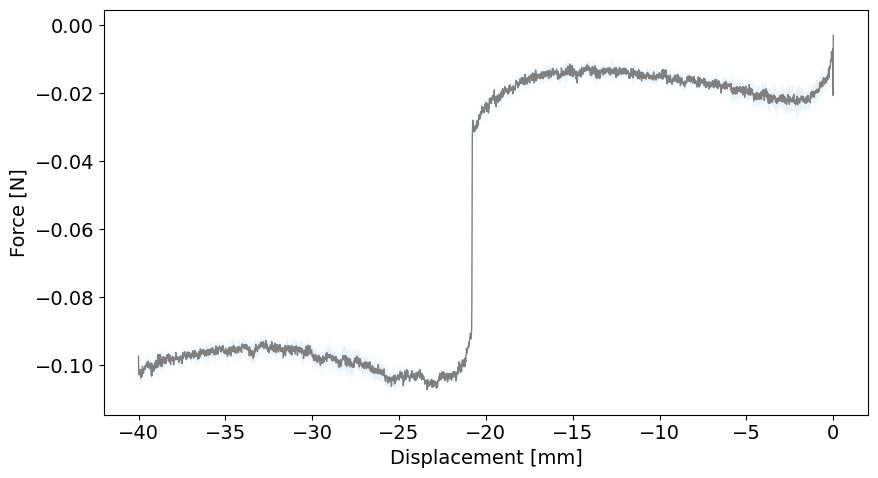

In [ ]:
friction_2Unit = sorted(list(Path('./2unit_11_00/2unit_Friction.is_tcyclic_Exports').glob("*.txt")))

fig, axes, unit2_friction_back = plot_average_curve(friction_2Unit, lw=1, color="gray", label="Experiment")

### Make plots

(3004,)
(3004,)
(3004,)
(3004,)
(3004,)
(3004,)
(3004,)
(3004,)
(3004,)
(3004,)
(3004,)
(3004,)


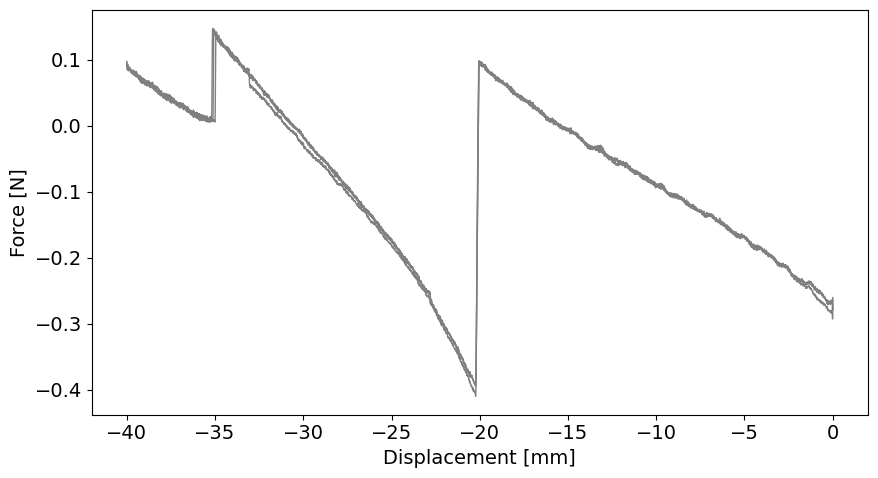

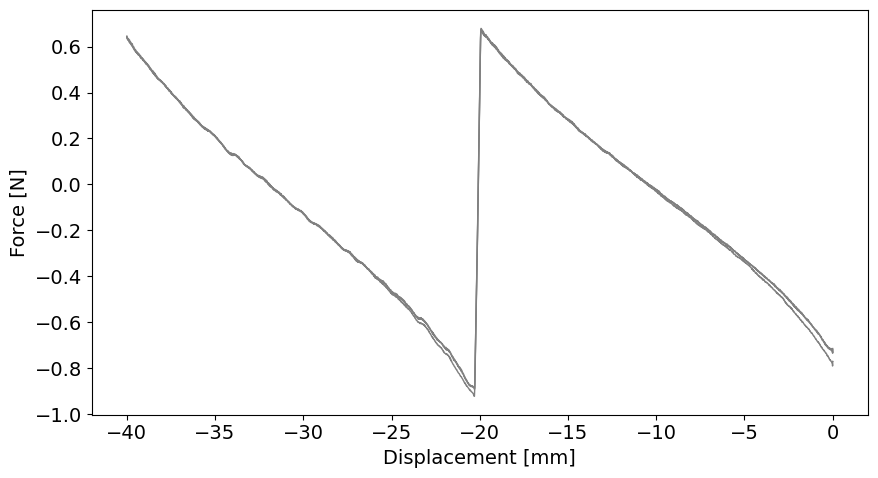

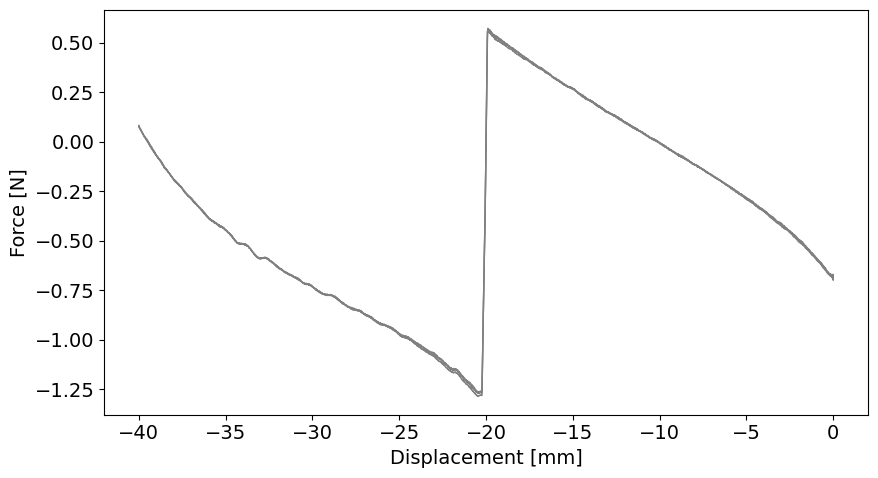

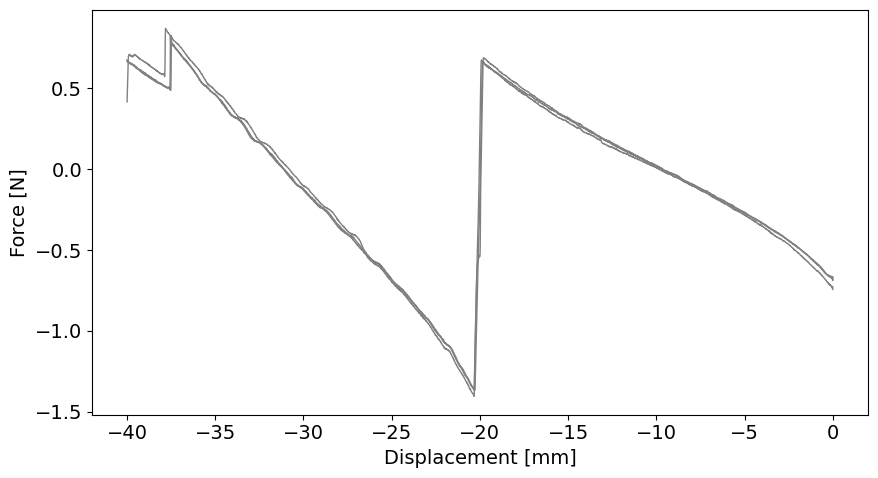

In [ ]:
data_MMB = sorted(
    list(Path('./15Aug_Tests/2unit/2unit_MMB.is_tcyclic_Exports').glob("*.txt"))
)
fig, axes = plot_raw_force_displacement_curves(data_MMB[:3], lw=1, color="gray", label="Experiment")

data_MMM = sorted(
    list(Path('./15Aug_Tests/2unit/2unit_MMM.is_tcyclic_Exports').glob("*.txt"))
)
fig, axes = plot_raw_force_displacement_curves(data_MMM[3:], lw=1, color="gray", label="Experiment")

data_MMR = sorted(
    list(Path('./15Aug_Tests/2unit/2unit_MMR.is_tcyclic_Exports').glob("*.txt"))
)
fig, axes = plot_raw_force_displacement_curves(data_MMR[3:], lw=1, color="gray", label="Experiment")

data_MMT = sorted(
    list(Path('./15Aug_Tests/2unit/2unit_MMT.is_tcyclic_Exports').glob("*.txt"))
)
fig, axes = plot_raw_force_displacement_curves(data_MMT[3:], lw=1, color="gray", label="Experiment")

MMM


<ipython-input-28-7cefa3e22ff8>:39: RuntimeWarning: invalid value encountered in arcsin
  return np.arcsin(u/r-np.sin(rot1))


MMB
MML
MMR
MMT


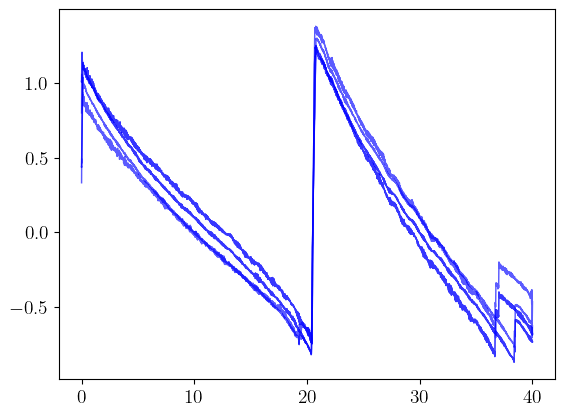

In [ ]:
#### backward paths

units = ['1unit','1unit_','2unit','2unit_2']
unit2_id1 = ['MMM','MMB','MML','MMR','MMT']
id_p2 =[[10,0],[0,0],[10,15],[10,-15],[20,0]]
id_p1 = [10,0]
p0_1 = [-10,0]
l_bar = 70
r = 10*np.sqrt(2)
u = np.linspace(20,-20,300)
rot1 = (np.linspace(-45,45,200))/180*np.pi

def plot_energy_curves_back(paths: List[str], syst_error,k,r,l,id,id_p, **plot_kwargs):
    # fig, axes = plt.subplots(figsize=(9, 5))
    # font = {'size': 14}
    # plt.rc('font', **font)


    #### analytical minimum path ####
    start_block, rot1_min, rot2_min, E_min, F_min = min_E_path(p0_1,id_p1,id_p2[id_p],k)

    #### Experimental data ####
    F = []
    Theta = []
    U = []
    for file in paths:
        _, u_exp, f_exp = read_instron_data(file)
        U.append(u_exp)
        F.append(f_exp)
    for i in range(len(U)):
        if len(U[i]) != len(U[0]):
            U_interp = interp1d(U[i], U[i], 'linear')
            F_interp = interp1d(U[i], F[i], 'linear')
            U[i],F[i] = U_interp(U[0]),F_interp(U[0])
            # U[i] = signal.resample(U[i],len(U[0]))
            # F[i] = signal.resample(F[i],len(U[0]))
            print(len(U[i]))
    mean_u, std_u = tolerant_mean(U)
    mean_f, std_f = tolerant_mean(F)
    err = signal.resample(unit2_friction,len(mean_f))
    if start_block == 0:
        mean_f -= err
    else:
        mean_f -= err[::-1]
    E_exp = integrate.cumtrapz(mean_f, mean_u, initial=0)

    #### Make plots ####
    plt.plot(mean_u, mean_f/(k*r),color='blue',alpha = 0.4,lw=1, **plot_kwargs,label = r'$F$   exp')

#     lns1 = axes.plot(mean_u, mean_f/(k*r),color='blue',alpha = 0.4,lw=1, **plot_kwargs,label = r'$F$   exp')
#     lns2 = axes.plot(u+20,F_min/(k*r),color='blue',lw =3,label = '     model')
#     #axes.fill_between(mean_theta, mean_f-std_f, mean_f+std_f, alpha=0.1)
#     axes.set(xlabel="Rotation [rad]", ylabel="Force [N]",title=id)
#     axes.set_ylabel("Force   "+ r'$\frac{F}{kr}$', color = 'blue', fontsize=18)
#     #axes.legend()
#     axes2=axes.twinx()
#     lns3 = axes2.plot(mean_u, E_exp/(k*r**2),color='red',alpha = 0.4,lw =3,**plot_kwargs, label = r'$E$   exp')
#     lns4 = axes2.plot(u+20,(E_min-E_min[0])/(k*r**2),color = 'red',lw=3,label = '    model')
#     #axes2.legend()
#    # axes.fill_between(mean_theta, mean_f-std_f, mean_f+std_f, alpha=0.1)
#     axes2.set(xlabel="Rotation [rad]", ylabel="Energy",title=id)
#     axes2.set_ylabel("Energy   " +r'$\frac{dE}{kr^2}$',color = 'red', fontsize=18)
#     fig.tight_layout()

#     lns = lns1+lns2+lns3+lns4
#     labs = [l.get_label() for l in lns]
#     axes.legend(lns, labs, loc=0, fontsize = 11)

    # fig, axes = plt.subplots(figsize=(9, 5))
    # axes.plot(mean_theta,np.gradient(E_exp,mean_u),color='blue',label = 'experiment')
    return F_min,mean_f,E_min,E_exp #,fig, axes

All_F_back = []
All_F_exp_back = []
All_E_back = []
All_E_exp_back = []
All_mean_theta_back = []
for idx, elem in enumerate(unit2_id1):
    unit1_data_back = sorted(list(Path(f'./15Aug_Tests/2unit/2unit_{elem}.is_tcyclic_Exports').glob("*.txt")))
    unit2_1_back = unit1_data_back[:3] #1 rubber band
    unit2_2_back = unit1_data_back[3:6] #2 rubber bands
    print(elem)
    F_min_back,F_exp_back,E_min_back,E_exp_back = plot_energy_curves_back(unit2_1,unit2_friction_back,k_rubber,r,l_bar,elem,idx)
    All_F_back.append(F_min_back)
    All_F_exp_back.append(F_exp_back)
    All_E_back.append(E_min_back)
    All_E_exp_back.append(E_exp_back)
    F_min_back,F_exp_back,E_min_back,E_exp_back = plot_energy_curves_back(unit2_2,unit2_friction_back,2*k_rubber, r,l_bar,elem,idx)
    All_F_back.append(F_min_back)
    All_F_exp_back.append(F_exp_back)
    All_E_back.append(E_min_back)
    All_E_exp_back.append(E_exp_back)

## Force displacement plots forward and backward

<ipython-input-28-1a576f3ddf63>:39: RuntimeWarning: invalid value encountered in arcsin
  return np.arcsin(u/r-np.sin(rot1))


<function matplotlib.pyplot.plot(*args, scalex=True, scaley=True, data=None, **kwargs)>

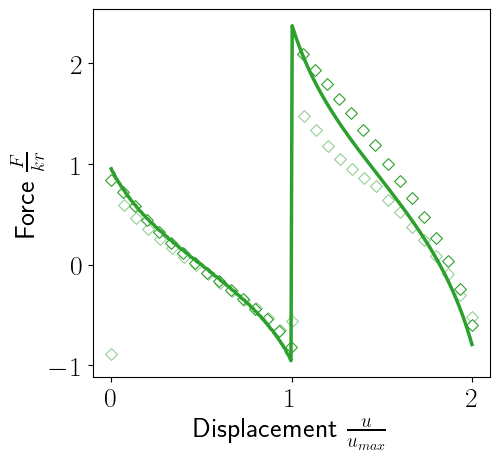

In [ ]:
#### Make plot of one specific case
units = ['1unit','1unit_','2unit','2unit_2']
unit2_id1 = ['MMM','MMB','MML','MMR','MMT']
id_p2 =[20,15]
id_p1 = [10,0]
p0_1 = [-10,0]
l_bar = 70
r = 10*np.sqrt(2)
u = np.linspace(20,-20,300)
rot1 = (np.linspace(-45,45,200))/180*np.pi

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

start_block, rot1_min, rot2_min, E_min, F_min = min_E_path(p0_1,id_p1,id_p2,k_rubber)
F_MTL = F_min/(k_rubber*r)
_,u_f,F_f = read_instron_data(MTL_2_f)
_,u_b,F_b = read_instron_data(MTL_2_b)
F_f[:len(F_f)//2]=F_f[:len(F_f)//2]-0.1
F_b[len(F_f)//2:]=F_b[len(F_f)//2:]-0.1


fig, axes = plt.subplots(figsize=(5.4, 5))
axes.plot(np.linspace(40,0,len(F_MTL)-2)/20,F_MTL[1:-1],lw = 2.5, color = colors[2])
axes.scatter((u_b[::100]+40)/20,F_b[::100]/(k_rubber_back*r),lw = 0.8, alpha =0.5,marker = 'D', edgecolors = colors[2], c = 'white')
axes.scatter(u_f[::100]/20,F_f[::100]/(k_rubber_back*r),lw = 0.8, alpha =1,marker = 'D', edgecolors = colors[2], c = 'white')

axes.set(xlabel="Displacement"+r" $\frac{u}{u_{max}}$",ylabel="Energy")
axes.set_ylabel("Force   " +r'$\frac{F}{kr}$')

plt.tight_layout()
fig.savefig(r'./2unit_MTL.pdf', dpi=600)
plt.plot